In [ ]:
!pip install torch torchvision matplotlib opencv-python timm tqdm requests

In [ ]:
import os
import shutil
import requests
import zipfile
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets
from tqdm import tqdm
import timm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_dir = """/content/drive/MyDrive/KoreaUniv/2024/DEEP_LEARNING/Final_Project"""

Mounted at /content/drive


In [ ]:
data_dir = drive_dir + "/datasets/Office-31/domain_adaptation_images"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
print(data_dir + '/amazon/images')
!ls -l {target_dir}

In [ ]:
batch_size = 32
learning_rate = 1e-4
num_epochs = 20

In [ ]:
source_dir = data_dir + '/amazon'
target_dir = data_dir + '/webcam'

source_dataset = datasets.ImageFolder(root=source_dir, transform=transform)
target_dataset = datasets.ImageFolder(root=target_dir, transform=transform)

source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)

Visualizing Amazon (Source Domain) Samples...


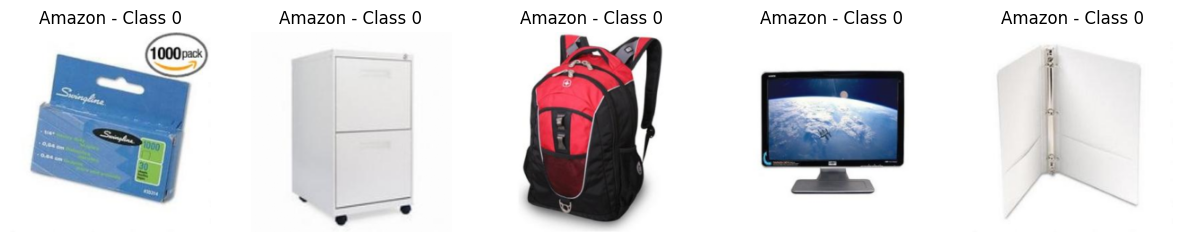

Visualizing Webcam (Target Domain) Samples...


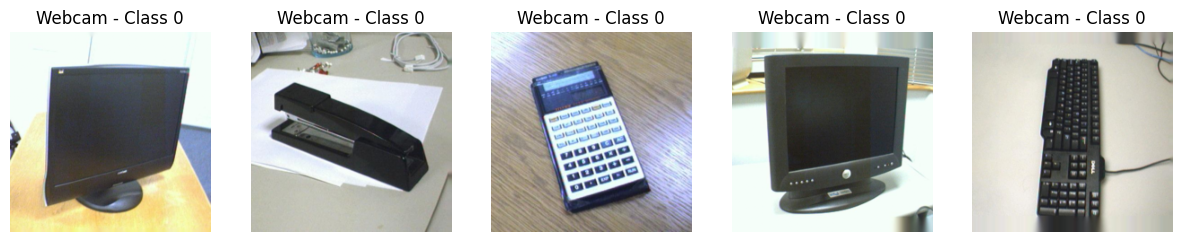

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 해제!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def visualize_samples(dataloader, domain_name, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        imshow(images[idx], title=f"{domain_name} - Class {labels[idx]}")
    plt.show()

print("Visualizing Amazon (Source Domain) Samples...")
visualize_samples(source_loader, domain_name="Amazon")

print("Visualizing Webcam (Target Domain) Samples...")
visualize_samples(target_loader, domain_name="Webcam")

In [ ]:
class ViTDomainAdaptation(nn.Module):
    def __init__(self, num_classes):
        super(ViTDomainAdaptation, self).__init__()
        self.feature_extractor = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.fc(features)
        return features, outputs

In [ ]:
model = ViTDomainAdaptation(num_classes=len(source_dataset.classes)).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
def coral_loss(source, target):
    d = source.size(1)
    source_cov = torch.mm(source.T, source) / source.size(0)
    target_cov = torch.mm(target.T, target) / target.size(0)
    loss = torch.norm(source_cov - target_cov, p="fro") ** 2 / (4 * d * d)
    return loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
classification_loss = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss, total_class_loss, total_coral_loss = 0, 0, 0

    source_iter = iter(source_loader)
    target_iter = iter(target_loader)

    for _ in tqdm(range(min(len(source_loader), len(target_loader)))):
        source_data, source_labels = next(source_iter)
        target_data, _ = next(target_iter)

        source_data, source_labels = source_data.to(device), source_labels.to(device)
        target_data = target_data.to(device)

        source_features, source_preds = model(source_data)
        target_features, _ = model(target_data)

        class_loss = classification_loss(source_preds, source_labels)
        domain_loss = coral_loss(source_features, target_features)

        loss = class_loss + 0.1 * domain_loss  # Trade-off

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_coral_loss += domain_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}, Class Loss: {total_class_loss:.4f}, Coral Loss: {total_coral_loss:.4f}")

100%|██████████| 9/9 [02:19<00:00, 15.53s/it]


Epoch [1/20], Total Loss: 0.0091, Class Loss: 0.0000, Coral Loss: 0.0913


100%|██████████| 9/9 [01:10<00:00,  7.78s/it]


Epoch [2/20], Total Loss: 0.0001, Class Loss: 0.0000, Coral Loss: 0.0010


100%|██████████| 9/9 [01:01<00:00,  6.87s/it]


Epoch [3/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0005


100%|██████████| 9/9 [00:58<00:00,  6.46s/it]


Epoch [4/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0002


100%|██████████| 9/9 [00:55<00:00,  6.16s/it]


Epoch [5/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0001


100%|██████████| 9/9 [00:47<00:00,  5.27s/it]


Epoch [6/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0001


100%|██████████| 9/9 [00:43<00:00,  4.84s/it]


Epoch [7/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0001


100%|██████████| 9/9 [00:39<00:00,  4.35s/it]


Epoch [8/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0001


100%|██████████| 9/9 [00:37<00:00,  4.12s/it]


Epoch [9/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:30<00:00,  3.43s/it]


Epoch [10/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0001


100%|██████████| 9/9 [00:32<00:00,  3.57s/it]


Epoch [11/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:29<00:00,  3.28s/it]


Epoch [12/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:26<00:00,  2.93s/it]


Epoch [13/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:23<00:00,  2.63s/it]


Epoch [14/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Epoch [15/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


Epoch [16/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:21<00:00,  2.41s/it]


Epoch [17/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:16<00:00,  1.81s/it]


Epoch [18/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


Epoch [19/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


100%|██████████| 9/9 [00:15<00:00,  1.73s/it]

Epoch [20/20], Total Loss: 0.0000, Class Loss: 0.0000, Coral Loss: 0.0000


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, labels in target_loader:
        data, labels = data.to(device), labels.to(device)
        _, outputs = model(data)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Accuracy on Webcam domain: {100 * correct / total:.2f}%")

Accuracy on Webcam domain: 100.00%
